In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

## 7.2 Conversion Testing Recap

In [3]:
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

In [4]:
alpha_prior = 1
beta_prior = 1

In [5]:
posterior_a = tfp.distributions.Beta(
    alpha_prior + conversions_from_A, 
    beta_prior + visitors_to_A - conversions_from_A)

posterior_b = tfp.distributions.Beta(
    alpha_prior + conversions_from_B, 
    beta_prior + visitors_to_B - conversions_from_B)

In [6]:
figsize = (12.5, 4)
x = np.linspace(0,1,500)

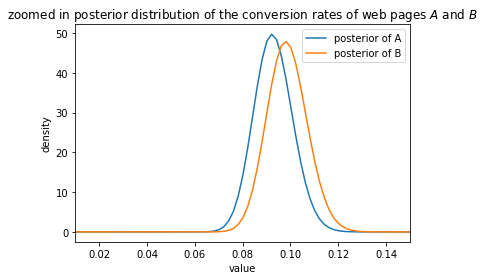

In [7]:
plt.plot(x, posterior_a.prob(x), label='posterior of A')
plt.plot(x, posterior_b.prob(x), label='posterior of B')
plt.xlim(0.01, 0.15)
plt.xlabel('value')
plt.ylabel('density')
plt.title("zoomed in posterior distribution of the conversion rates of web pages $A$ and $B$")
plt.legend()

## 7.3 Adding a linear loss function

### 7.3.1 Expected revenue analysis

In [8]:
N = 1
p = [0.5, 0.2, 0.3]
tfp.distributions.Multinomial(N, probs=p).sample().numpy()

array([1., 0., 0.], dtype=float32)

In [9]:
N=10
tfp.distributions.Multinomial(N, probs=p).sample().numpy()

array([7., 0., 3.], dtype=float32)

In [10]:
sample = tfp.distributions.Dirichlet([1,1]).sample().numpy()
sample

array([0.20531769, 0.79468226], dtype=float32)

In [11]:
sample.sum()

0.99999994

In [12]:
sample = tfp.distributions.Dirichlet([1,1,1,1]).sample().numpy()
sample

array([0.32740894, 0.12447099, 0.36726162, 0.18085845], dtype=float32)

In [13]:
sample.sum()

0.99999994

In [14]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

In [15]:
observations = tf.constant([N_79, N_49, N_25, N_0], dtype=float)
prior_parameters = tf.constant([1,1,1,1], dtype=float)

In [16]:
posterior_samples = tfp.distributions.Dirichlet(observations + prior_parameters).sample(10000).numpy()

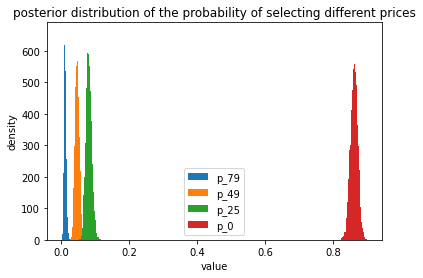

In [17]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50, label=label, histtype='stepfilled')
    
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the probability of selecting different prices')
plt.legend()

In [18]:
def expected_revenue(p):
    return np.dot(p, np.array([79, 49, 25, 0]))

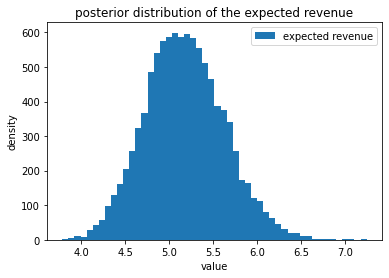

In [19]:
posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, bins=50, label='expected revenue', histtype='stepfilled')
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the expected revenue')
plt.legend()

In [20]:
from tensorflow_probability.python.math.psd_kernels.polynomial import Polynomial

In [21]:
p = Polynomial(slope_variance = tf.constant([2.0,2.0]))

In [22]:
p._batch_shape()

TensorShape([2])

In [23]:
p._apply(tf.ones(shape=(2,1), dtype=tf.float32),tf.ones(shape=(2,1), dtype=tf.float32), 1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4., 4.],
       [4., 4.]], dtype=float32)>

In [24]:
import functools
from tensorflow_probability.python.internal import tensor_util
feature_ndims=1
volatility = tensor_util.convert_nonref_to_tensor(
          1.0, name='volatility', dtype=tf.float32)

### 7.3.2 Extending to an A/B experiment

In [25]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = tf.constant([N_A_79, N_A_49, N_A_25, N_A_0], dtype=float)
observations_A

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 10.,  46.,  80., 864.], dtype=float32)>

In [26]:
N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = tf.constant([N_B_79, N_B_49, N_B_25, N_B_0], dtype=float)
observations_B

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([  45.,   84.,  200., 1671.], dtype=float32)>

In [27]:
prior_parameters = tf.ones(4)
prior_parameters

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

In [28]:
posterior_samples_A = tfp.distributions.Dirichlet(observations_A + prior_parameters).sample(10000).numpy()

In [29]:
posterior_samples_B = tfp.distributions.Dirichlet(observations_B + prior_parameters).sample(10000).numpy()

In [30]:
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)

In [31]:
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

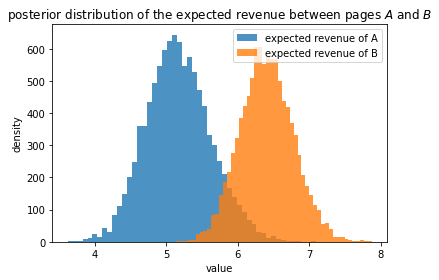

In [32]:
plt.hist(posterior_expected_revenue_A, bins=50, label='expected revenue of A', histtype='stepfilled', alpha=0.8)
plt.hist(posterior_expected_revenue_B, bins=50, label='expected revenue of B', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the expected revenue between pages $A$ and $B$')
plt.legend()

In [33]:
(posterior_expected_revenue_B > posterior_expected_revenue_A).mean()

0.9807

In [34]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A

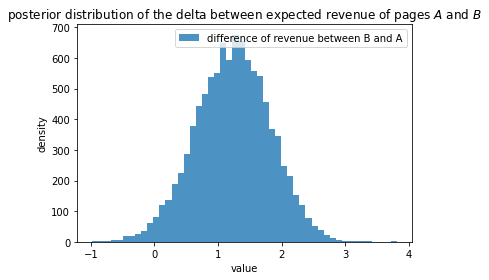

In [35]:
plt.hist(posterior_diff, bins=50, label='difference of revenue between B and A', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of the delta between expected revenue of pages $A$ and $B$')
plt.legend()

## 7.4 Going beyond conversions: t-test

In [36]:
N = 250
mu_A, std_A = 30, 4 
mu_B, std_B = 26, 7

In [37]:
durations_A = tfp.distributions.Normal(mu_A, std_A).sample(N)
durations_B = tfp.distributions.Normal(mu_B, std_B).sample(N)

In [38]:
pooled_mean = tf.math.reduce_mean(tf.stack([durations_A, durations_B]))
pooled_std = tf.math.reduce_std(tf.stack([durations_A, durations_B]))
tau = 1./tf.math.sqrt(1000.0*pooled_std)

In [39]:
def durations(durations_A, durations_B, mu_A, mu_B, std_A, std_B, tau):
    pooled_mean = tf.math.reduce_mean(tf.stack([durations_A, durations_B]))
    pooled_std = tf.math.reduce_std(tf.stack([durations_A, durations_B]))
    tau = tf.math.sqrt(1000.0*pooled_std)

    nu_minus_1 = tfp.distributions.TransformedDistribution(
        tfp.distributions.Exponential(1/29.0, name='nu_1'),
        bijector=tfp.bijectors.Chain([tfp.bijectors.Shift(shift=1.), tfp.bijectors.Invert(tfp.bijectors.Identity())])
    )

    durations_posterior_A = tfp.distributions.JointDistributionNamed(
        dict(
            x=tfp.distributions.Normal(pooled_mean, tau, name='mu_A'),
            y=tfp.distributions.TransformedDistribution(tfp.distributions.Uniform(pooled_std/1000.0, 1000.0*pooled_std, name='std_A'), bijector=tfp.bijectors.Invert(tfp.bijectors.Square())),
            z=nu_minus_1,
            obs=lambda x, y, z: tfp.distributions.Independent(
                tfp.distributions.StudentT(df=z[..., tf.newaxis], loc=x[..., tf.newaxis], scale=y[..., tf.newaxis], name="obs_A"),
                reinterpreted_batch_ndims=1
            )
        )
    )
    
    durations_posterior_B = tfp.distributions.JointDistributionNamed(
        dict(
            x=tfp.distributions.Normal(pooled_mean, tau, name='mu_A'),
            y=tfp.distributions.TransformedDistribution(tfp.distributions.Uniform(pooled_std/1000.0, 1000.0*pooled_std, name='std_N'), bijector=tfp.bijectors.Invert(tfp.bijectors.Square())),
            z=nu_minus_1,
            obs=lambda x, y, z: tfp.distributions.Independent(
                tfp.distributions.StudentT(df=z[..., tf.newaxis], loc=x[..., tf.newaxis], scale=y[..., tf.newaxis], name="obs_B"),
                reinterpreted_batch_ndims=1
            )
        )
    )

    return durations_posterior_A, durations_posterior_B

In [40]:
durations_dist_A, durations_dist_B = durations(
    durations_A, 
    durations_B, 
    mu_A,
    mu_B,
    std_A, 
    std_B, 
    tau
)

In [41]:
def log_prob_fn(model, x, y, z, obs):
    return model.log_prob(x=x, y=y, z=z, obs=obs)

In [42]:
def get_log_proba_fn_fn(posterior_A, posterior_B):
    def get_log_proba_fn(durations_A, durations_B):
        return lambda x,y,z,u,v: log_prob_fn(posterior_A, x, y, z, durations_A)+log_prob_fn(posterior_B, u, v, z, durations_B)
    return get_log_proba_fn

In [43]:
num_results = 25000
num_burnin_steps = 10000

In [44]:
def get_initial_states():
    return [
        tf.math.reduce_mean(durations_A) * tf.ones([], dtype=tf.float32, name="init_mu_A"),
        tf.math.reduce_std(durations_A) * tf.ones([], dtype=tf.float32, name="init_std_A"),
        (tf.math.reduce_mean(tfp.distributions.Exponential(1/29.0).sample(1000)))* tf.ones([], dtype=tf.float32, name="init_nu-1"),
        tf.math.reduce_mean(durations_B) * tf.ones([], dtype=tf.float32, name="init_mu_B"),
        tf.math.reduce_std(durations_B) * tf.ones([], dtype=tf.float32, name="init_std_B"),
    ]

In [45]:
@tf.function(autograph=False, experimental_compile=False)
def sample():
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=get_log_proba_fn_fn(durations_dist_A, durations_dist_B)(durations_A, durations_B),
              step_size=0.3,
              num_leapfrog_steps=5
    )
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=get_initial_states(),
        kernel=kernel,
    )

In [46]:
states, kernel_results = sample()

/usr/local/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


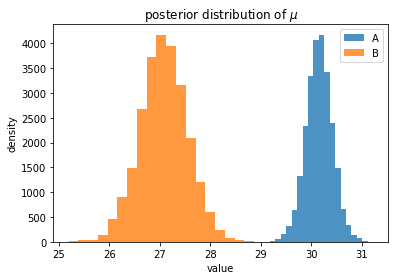

In [49]:
plt.hist(states[0].numpy(), bins=20, label='A', histtype='stepfilled', alpha=0.8)
plt.hist(states[3].numpy(), bins=20, label='B', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of $\mu$')
plt.legend()

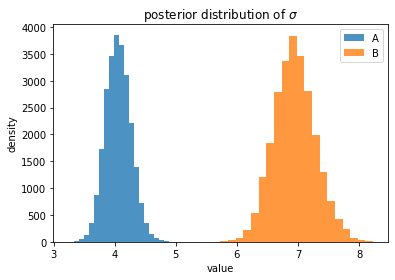

In [50]:
plt.hist(states[1].numpy(), bins=20, label='A', histtype='stepfilled', alpha=0.8)
plt.hist(states[4].numpy(), bins=20, label='B', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of $\sigma$')
plt.legend()

No handles with labels found to put in legend.


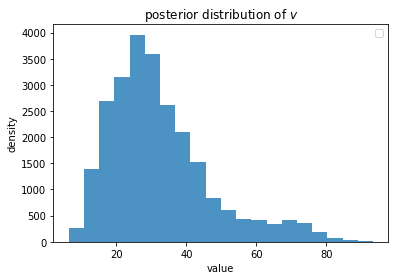

In [51]:
plt.hist(states[2].numpy(), bins=20, histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distribution of $v$')
plt.legend()

## 7.5 Estimating the increase

In [52]:
visitors_to_A = 1275
visitors_to_B = 1300

In [55]:
conversions_from_A = 22
conversions_from_B = 12

In [54]:
alpha_prior = 1
beta_prior = 1

In [56]:
posterior_A = tfp.distributions.Beta(
    alpha_prior + conversions_from_A,
    beta_prior + visitors_to_A - conversions_from_A
)

posterior_B = tfp.distributions.Beta(
    alpha_prior + conversions_from_B,
    beta_prior + visitors_to_B - conversions_from_B
)

In [62]:
samples = 20000

In [63]:
samples_posterior_A = posterior_A.sample(samples)
samples_posterior_B = posterior_B.sample(samples)

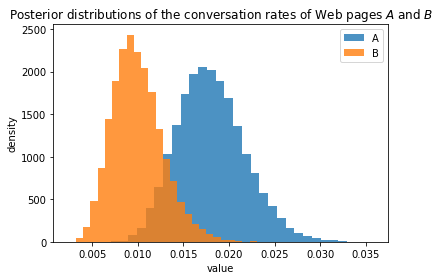

In [74]:
plt.hist(samples_posterior_A.numpy(), bins=30, label='A', histtype='stepfilled', alpha=0.8)
plt.hist(samples_posterior_B.numpy(), bins=30, label='B', histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title('Posterior distributions of the conversation rates of Web pages $A$ and $B$')
plt.legend()

In [66]:
def relative_increase(a, b):
    return (a-b)/b

In [67]:
posterior_rel_increase = relative_increase(samples_posterior_A.numpy(), samples_posterior_B.numpy())

No handles with labels found to put in legend.


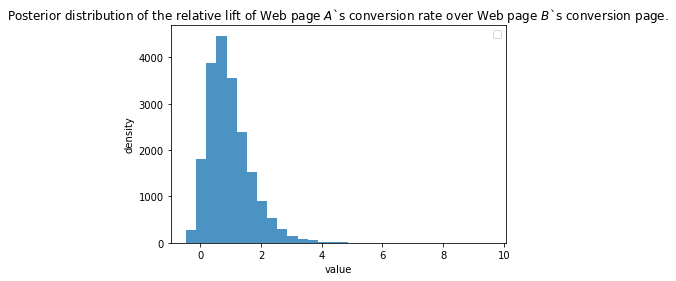

In [75]:
plt.hist(posterior_rel_increase, bins=30, histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.title(
    'Posterior distribution of the relative lift of Web page $A$`s conversion rate over Web page $B$`s conversion page.'
)
plt.legend()

In [77]:
print((posterior_rel_increase > 0.2).mean())
print((posterior_rel_increase > 0.5).mean())

0.89215
0.71965


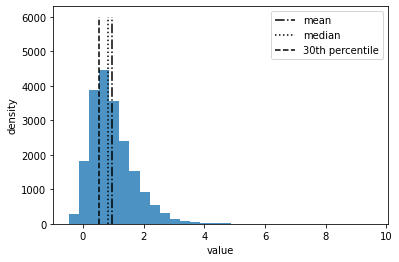

In [85]:
mean = posterior_rel_increase.mean()
median = np.quantile(posterior_rel_increase, 0.50)
convervative_percentile = np.quantile(posterior_rel_increase, 0.30)

plt.vlines(mean, 0, 6000, linestyles='-.', label='mean', color='#000')
plt.vlines(median, 0, 6000, linestyles=':', label='median', color='#000')
plt.vlines(convervative_percentile, 0, 6000, linestyles='--', label='30th percentile', color='#000')

plt.hist(posterior_rel_increase, bins=30, histtype='stepfilled', alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.legend()